In [1]:
import glob, pylab, pandas as pd
import pydicom, numpy as np
from os import listdir
from os.path import isfile, join
import cv2 as cv
import matplotlib.pylab as plt
import os

# File path 설정

In [3]:
base_path = 'C:\\Users\\User\\Desktop\\spine\\'

images_path = base_path + 'sample'
images_list = [s for s in listdir(images_path) if isfile(join(images_path, s))]

print('Total File sizes')
for f in os.listdir(base_path):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize(base_path + '\\' + f) / 1000000, 2)) + 'MB')
        #font size 30, 왼쪽정렬

print('The number of slices:', len(images_list))


Total File sizes
sample                        0.05MB
seg.dcm                       3.45MB
seg.nrrd                      0.11MB
The number of slices: 104


# DICOM data checking

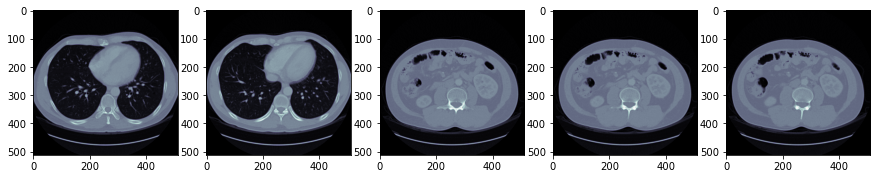

In [4]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 1
img_list = []
for i in range(1, columns * rows + 1):
    dcm = pydicom.dcmread(images_path + '/' + images_list[i - 1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(dcm.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot
    img_list.append(dcm.pixel_array)

# DICOM image 및 Mask image Load

In [10]:
#%% dicom load
img_list = []
for i in range(len(images_list)):
    dcm = pydicom.dcmread(images_path + '\\' + images_list[i])
    img_list.append(dcm.pixel_array)
    print(i)
print("DICOM images load completed")


#%% mask load 
msk = pydicom.dcmread('C:\\Users\\User\\Desktop\\spine\\seg.dcm')
d = msk.pixel_array
msk_img = np.transpose(d, (1, 2, 0))
msk_img_array = np.array(msk_img)
print("mask images load completed")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
DICOM images load completed
mask images load completed


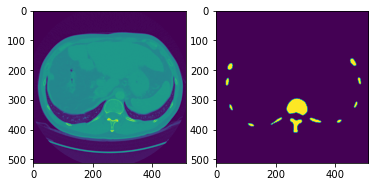

In [23]:
slice_num = 50

plt.subplot(121)
plt.imshow(img_list[slice_num])
plt.subplot(122)
plt.imshow(d[103 - slice_num, :, :])

# HU correction

In [24]:
def hu_correction(dcm, img):

    image = img.astype(np.int16)
    
    intercept = dcm.RescaleIntercept
    slope = dcm.RescaleSlope
    
        # Convert to Hounsfield units (HU)
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
            
    image += np.int16(intercept)
    
    image[image < np.min(image)] = np.min(image)
    image[image > np.max(image)] = np.max(image)
    
    return np.array(image, dtype=np.int16)


In [25]:
seg_list = []
for i in range(len(img_list)):
    img = hu_correction(dcm, img_list[i])
    seg = img * msk_img_array[:, :, len(img_list)- 1 - i]
    print(i)
    seg_list.append(seg)

print("------------segmentation completed--------------")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
------------segmentation completed--------------


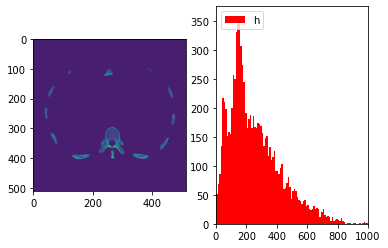

In [36]:
slice_num = 0

plt.subplot(121)
plt.imshow(seg_list[slice_num])
plt.subplot(122)
plt.hist(seg_list[slice_num].flatten(),100,[1,1000], color = 'r')
plt.xlim([0,1000])
plt.legend('histogram', loc = 'upper left')
plt.show()

# ROI Extraction

In [27]:
def roi_extraction(img, min_value, max_value):
    inputimg = img
    i = 0
    j = 0
    img_f = np.zeros(inputimg.shape)
    for i in range(inputimg.shape[0]):
        for j in range(inputimg.shape[1]):
            if inputimg[i, j] > int(min_value) and inputimg[i, j] < int(max_value):
                img_f[i, j] = 1
            else:
                img_f[i, j] = 0
    
    area_count = np.count_nonzero(img_f == 1)
    
    return img_f, area_count


In [31]:
roiimg_1, roi_cnt_1 = roi_extraction(seg_list[0], -1024, 0)

area_1 = roi_cnt_1 * float(dcm.SliceThickness) * float(dcm.PixelSpacing[0])
print("-1024 ~ 0 volume(1st slice) is " + str(area_1) + " cm^3")



-1024 ~ 0 volume(1st slice) is 369.0234375 cm^3


In [29]:
voi_cnt_1 = 0
voi_img_1 = []
for idx in range(len(seg_list)):
    voi_img, voi_cnt = roi_extraction(seg_list[idx], -1024, 0)
    voi_img_1.append(voi_img)
    voi_cnt_1 += voi_cnt
    print(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103


In [32]:
vol_1 = voi_cnt_1 * float(dcm.SliceThickness) * float(dcm.PixelSpacing[0])
print("-1024 ~ 0 volume is " + str(vol_1) + " cm^3")

-1024 ~ 0 volume is 95198.232421875 cm^3
